In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("data/WMInventoryData2016To2018.txt", sep='|', encoding="ISO-8859-1",
                 dtype={"UPC":"str"}, parse_dates=["POSDate"])

In [ ]:
df.columns

In [ ]:
df.head()

| ItemNbr | ItemFlags | ItemDescription | UPC | StoreNbr | CurrStrOnHandQty | CurrStrInTransitQty | CurrStrOnOrderQty | CurrStrInWhseQty | AvgInStockPercent | CurrInStockPercent | StoreWeekSupply | CurrTraitedStoreItemComb | CurrValidStoreItemComb | POSDate |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Is not one to one with UPC | Null | Brands | UPC | Store Number | # items in store | # items on their way to store | # items ordered for store | Current stock in Warehouse? | Newer Metric. Only appears as of Sep_2018 | - | - | - | - | Date |

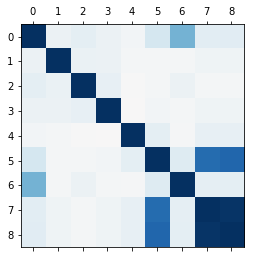

In [88]:
plt.matshow(df[df.columns[3:-1]].corr(), vmin=-1, vmax=1, cmap=plt.cm.RdBu)

In [7]:
df.drop(columns = ['ItemFlags', 'StoreNbr'], inplace=True)

In [8]:
df.columns[3:7].tolist() + df.columns[10:-1].tolist()

['CurrStrOnHandQty',
 'CurrStrInTransitQty',
 'CurrStrOnOrderQty',
 'CurrStrInWhseQty',
 'CurrTraitedStoreItemComb',
 'CurrValidStoreItemComb']

In [13]:
agg_dict = {}

#Are these the right columns to sum/avg?
cols_to_sum = df.columns[3:7].tolist() + df.columns[10:-1].tolist()
cols_to_avg = df.columns[7:10]
    
for col in cols_to_sum:
    agg_dict[col] = np.sum

for col in cols_to_avg:
    agg_dict[col] = np.mean

In [ ]:
df.groupby(["POSDate", "UPC"]).mean().head()

In [10]:
from helper_save_load import load_from_pickle

df_a, df_f, df_v = load_from_pickle("data/dataframes_Dollars.pickle")
del df_a, df_f

In [11]:
df_v = df_v.loc[:,~df_v.columns.duplicated()]

item_to_brand = df_v[["UPC_code", "Brand"]].groupby("UPC_code", as_index=False).first()
item_to_brand.columns = ["UPC", "Brand"]
item_to_brand["UPC"] = pd.to_numeric(item_to_brand["UPC"])

In [ ]:
inv_by_items = df.groupby(["POSDate", "UPC"], as_index=False).mean()
inv_by_items["UPC"] = pd.to_numeric(inv_by_items["UPC"])
inv_by_items.head()

In [ ]:
# Match UPC to variance data brands
inv_with_brands = inv_by_items.merge(item_to_brand, on=["UPC"])
inv_with_brands.head()

In [103]:
from helper_save_load import save_to_pickle

save_to_pickle('data/inventory_with_brands.pickle', inv_with_brands)

In [ ]:
# Grouped by (Day(D), Week(W), Month(M)) and Brand
inv_grouped_brands = inv_with_brands.groupby([inv_with_brands["POSDate"].dt.to_period("M"), "Brand"]).agg(
                                            agg_dict).reset_index()
inv_grouped_brands.head()

In [101]:
from helper_save_load import save_to_pickle

save_to_pickle('data/monthly_inventory_with_brands.pickle', inv_grouped_brands)

In [78]:
inv_grouped_brands['POSDate'] = pd.to_datetime(inv_grouped_brands['POSDate'].astype(str)).dt.strftime('%b_%Y')

In [80]:
months = inv_grouped_brands['POSDate'].unique().tolist()

In [96]:
monthly_inv_pivot = pd.pivot_table(inv_grouped_brands, index='Brand', columns='POSDate', values='CurrStrOnHandQty')
monthly_inv_pivot = monthly_inv_pivot.reindex(months, axis=1)
monthly_inv_pivot.fillna(0, inplace=True)

brands = monthly_inv_pivot.index.tolist()
monthly_inv_data = monthly_inv_pivot.values

In [98]:
unique_brand_month_pairs = df_c[~df_c['Num'].duplicated()][['Num', 'Brand_1', 'Month']]

monthly_inv_windows = []
for i, row in unique_brand_month_pairs.iterrows():
    month_idx = months.index(row['Month'])
    brand_idx = brands.index(row['Brand_1'])
    
    if month_idx - WINDOW_SIZE < 0:
        padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than WINDOW_SIZE
        window = np.concatenate((padding, monthly_inv_data[brand_idx, :month_idx+1]))
    else:
        window = monthly_inv_data[brand_idx, (month_idx-WINDOW_SIZE+1):month_idx+1]
        
    assert(len(window) == WINDOW_SIZE)
    monthly_inv_windows.append(window)
    
monthly_inv_windows = np.array(monthly_inv_windows)

NameError: name 'df_c' is not defined

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

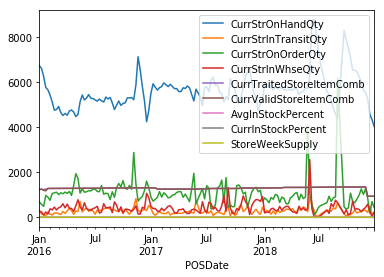

In [55]:
inv_grouped_brands[inv_grouped_brands["Brand"] == "05-AXE SA Brand"].plot(x="POSDate")

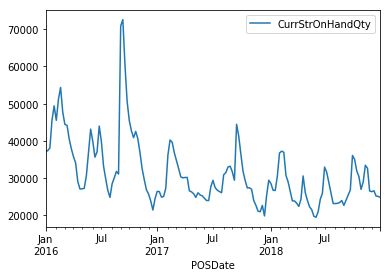

In [106]:
inv_grouped_brands[inv_grouped_brands["Brand"] == "19-DOVE BAR MENS+CARE Brand"].plot(x="POSDate", y="CurrStrOnHandQty")

In [ ]:
inv_grouped_brands[(inv_grouped_brands["AvgInStockPercent"] > 0)]

In [ ]:
inv_grouped_brands.corr()

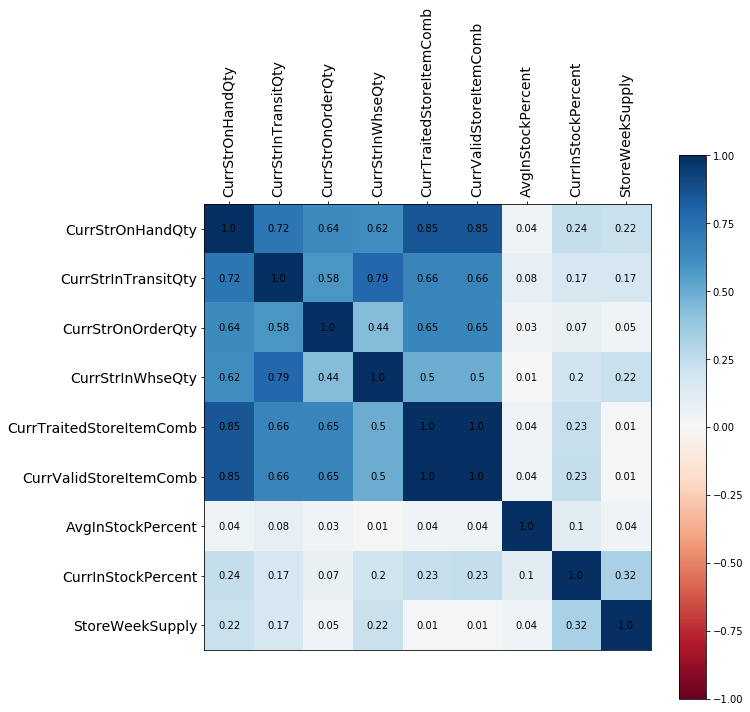

In [105]:


fig, ax = plt.subplots(figsize=(10,10))

cor_mat = ax.matshow(inv_grouped_brands.corr(), vmin=-1, vmax=1, cmap=plt.cm.RdBu)
ticks = [i for i in range(len(inv_grouped_brands.columns[2:]))]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(inv_grouped_brands.columns[2:], rotation=90, fontsize=14)
ax.set_yticklabels(inv_grouped_brands.columns[2:], fontsize=14)

corr_text = np.round(np.array(inv_grouped_brands.corr()), 2)
for i in range(9):
    for j in range(9):
        text = ax.text(j, i, corr_text[i, j], ha="center", va="center")
        
ax.tick_params(axis='both', bottom=False, right=False)
fig.colorbar(cor_mat)
plt.show()
        

In [ ]:


fig, ax = plt.subplots(figsize=(10,10))

cor_mat = ax.matshow(inv_grouped_brands.corr(), vmin=-1, vmax=1, cmap=plt.cm.RdBu)
ticks = [i for i in range(len(inv_grouped_brands.columns[2:]))]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(inv_grouped_brands.columns[2:], rotation=90, fontsize=14)
ax.set_yticklabels(inv_grouped_brands.columns[2:], fontsize=14)

corr_text = np.round(np.array(inv_grouped_brands.corr()), 2)
for i in range(9):
    for j in range(9):
        text = ax.text(j, i, corr_text[i, j], ha="center", va="center")
        
ax.tick_params(axis='both', bottom=False, right=False)
fig.colorbar(cor_mat)
plt.show()
        